In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
from torch import nn
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math

In [4]:
# Загрузка датасета mnist в даталоадер и трансформация изображений

mnist_transforms = T.Compose(
    [
        T.Resize((64,64)),
        T.ToTensor()
    ]
)

train_dataset = MNIST("mnist", train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST("mnist", train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle=False, num_workers=4, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 154696867.21it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68207034.81it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35680559.03it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw




/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
len(valid_loader)

313

In [19]:
# функция обучения 

def train(model:nn.Module, train_loader:torch.utils.data.DataLoader, loss_fn, optimizer:torch.optim, device:str):
    model.train()
    
    train_loss = 0
    embs = []
    
    
    for x,_ in tqdm(train_loader, desc = "Train"):
        x = x.to(device)
        
        optimizer.zero_grad()
        
        output = model(x)
        
        embs.append(output)
        
        loss = loss_fn(output,x)
        
        train_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
    
    train_loss /= len(train_loader)
    
    return train_loss, embs
        

In [20]:
# функция предсказаний модели

@torch.inference_mode()
def evaluate(model:nn.Module, valid_loader:torch.utils.data.DataLoader, loss_fn, device):
    model.eval()

    total_loss = 0
    embs = []
    
    for x, _ in tqdm(valid_loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)
        
        embs.append(output)
        
        loss = loss_fn(output, x)

        total_loss += loss.item()

    total_loss /= len(valid_loader)

    return total_loss, embs

In [8]:
# визуализация процесса обучения

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
from torchvision.utils import make_grid


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis('off')

    plt.show()

In [21]:
def whole_train_valid_cycle(model, train_loader, valid_loader, num_epochs, loss_fn, optimizer, device, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_ebeddings = train(model, train_loader, loss_fn, optimizer, device)
        valid_loss, valid_ebeddings = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)
        
        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )
    return train_ebeddings, valid_ebeddings

In [51]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class DenoisingBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4): # поменял base_size с 32 и num_blocks
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = DenoisingBlock, base_size: int = 32, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(1,DenoisingBlock,base_size = 8).to(device)

loss_fn = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=1e-3)

In [96]:
torch.cuda.empty_cache()

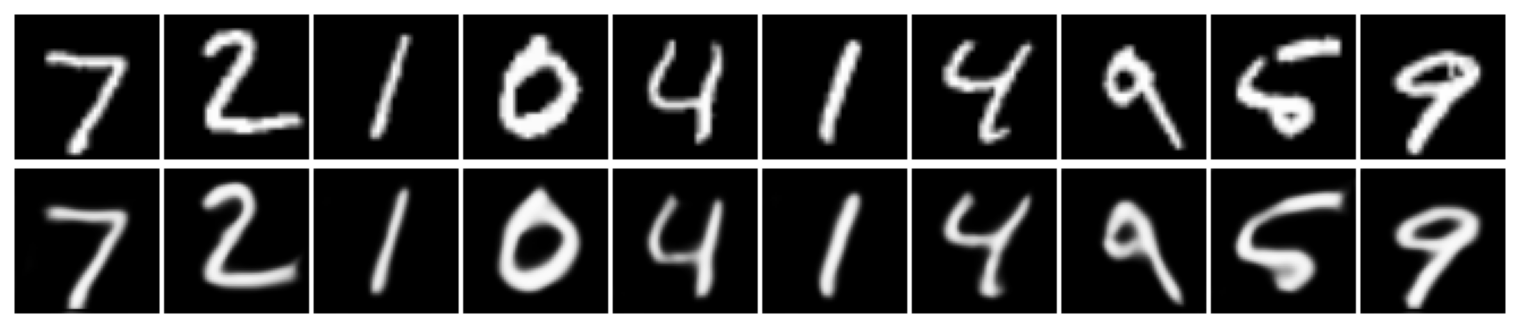

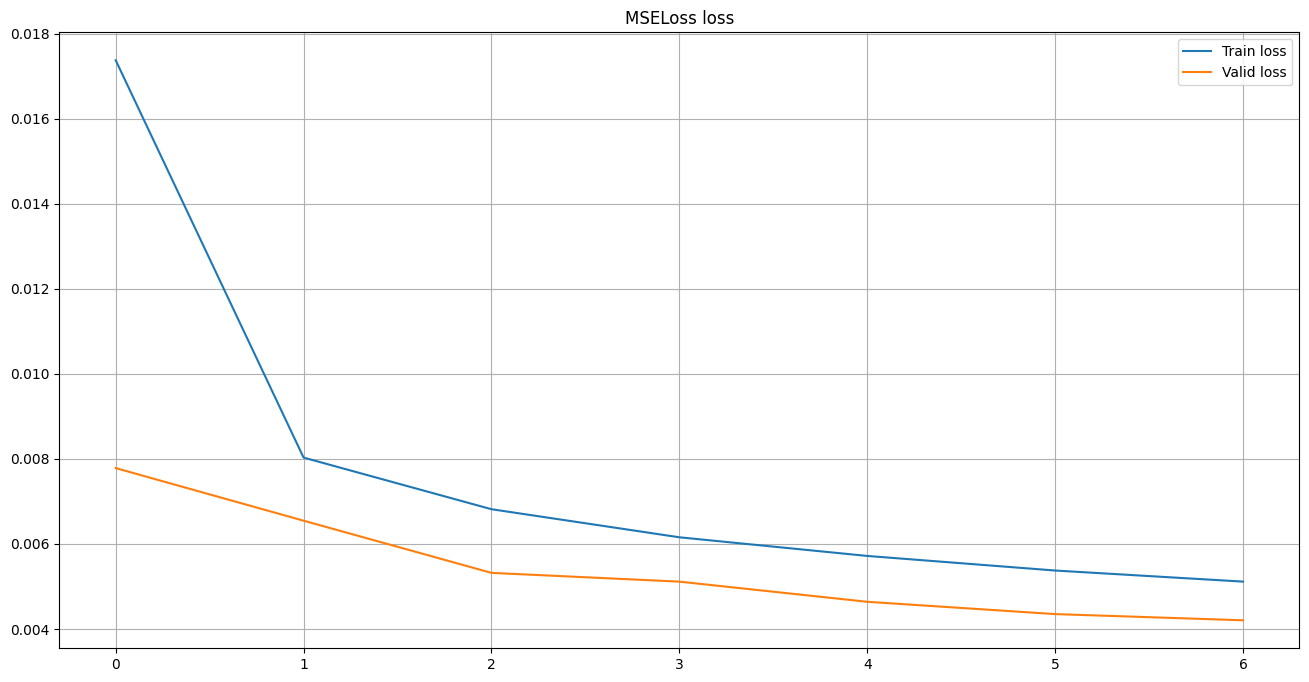

In [97]:
train_embs, valid_embs = whole_train_valid_cycle(model,train_loader,valid_loader,7,loss_fn, optimizer,device, "MSELoss")

In [89]:
train_embs[0][0][0].shape

torch.Size([64, 64])

In [90]:
train_embs[0].shape

torch.Size([32, 1, 64, 64])

In [57]:
model.encode(train_embs[0]).shape

torch.Size([32, 512])

In [113]:
@torch.inference_mode()
def get_embedding(model:nn.Module,x:torch.Tensor, device):
    """Эмбеддинг из модели"""
    
    z = model.encode(x.unsqueeze(0).to(device))
    return z

In [114]:

def embeddings_from_model(model, dataset, train=True, device = "cuda:0") -> (torch.Tensor, list):
    """Эмбеддинги для отдельных срезов из датасетов"""
    
    if train == True:
        num = 1000
    
    else:
        num = 10000
    
    embeddings = []
    targets = []
    for _ in range(num):
        idx = np.random.randint(len(dataset))
        embedding = get_embedding(model, dataset[idx][0], device)
        embeddings.append(embedding)
        targets.append(dataset[idx][1])
        
    
    tensor = torch.stack(embeddings) 
    
    return tensor.squeeze(dim=1), targets

In [134]:
X_train,y_train = embeddings_from_model(model, train_dataset)

In [121]:
X_train.shape, len(y_train)

(torch.Size([1000, 128]), 1000)

In [135]:
X_valid, y_valid = embeddings_from_model(model,valid_dataset,train==False)

In [120]:
X_valid.shape, len(y_valid)

(torch.Size([10000, 128]), 10000)

In [132]:
def transform_features(X:torch.tensor, y:list) -> (np.array, np.array):
    X = X.clone()
    Y = np.array(y)
    return X.cpu().numpy(), Y

In [136]:
X_train, y_train = transform_features(X_train, y_train)

In [137]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)

forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [138]:
X_valid, y_valid = transform_features(X_valid, y_valid)

In [139]:
forest.score(X_valid, y_valid)

0.9152

In [140]:
def save_embeddings(x_train, y_train, x_valid, y_valid):
    assert x_train.shape[0] == 1000
    assert x_valid.shape[0] == 10000
    
    assert y_train.shape[0] == 1000
    assert y_valid.shape[0] == 10000

    torch.save(
        {
            'x_train': x_train,
            'y_train': y_train,
            'x_valid': x_valid,
            'y_valid': y_valid
        },
        'embeddings.pt'
    )

In [141]:
file = save_embeddings(X_train, y_train, X_valid, y_valid)